# Decision Trees and Models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

data = pd.read_csv('/content/drive/My Drive/TFMSandoz/GonYari/df_Ready_For_Model_1709.csv')

In [3]:
data

,family_id,Total_A,Total_B,Total_Success_Rate,num_europe,num_europe_B,patent_family_success_rate_europe,num_america,num_america_B,patent_family_success_rate_america,...,PatentFamily_Type_U,PatentFamily_Type_D1,PatentFamily_Type_C2,PatentFamily_Type_A9,PatentFamily_Type_C,PatentFamily_Type_A2,PatentFamily_Type_C1,PatentFamily_Type_A3,PatentFamily_Type_T3,PatentFamily_Type_total
0,1.0,9,2,22.222222,3,1,0.333333,3,0,0.000000,...,0,1,0,0,0,0,0,0,0,13
1,2.0,11,5,45.454545,3,1,0.333333,3,1,0.333333,...,0,1,0,0,0,1,0,0,0,16
2,3.0,11,2,18.181818,4,1,0.250000,4,1,0.250000,...,0,1,0,0,0,1,0,0,0,13
3,4.0,6,1,16.666667,2,1,0.500000,2,0,0.000000,...,0,1,0,0,0,0,0,0,2,12
4,5.0,46,10,21.739130,7,2,0.285714,17,1,0.058824,...,0,1,0,0,0,6,0,0,1,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,61.0,36,12,33.333333,3,0,0.000000,10,5,0.500000,...,0,0,0,0,0,0,0,0,0,48
61,62.0,7,3,42.857143,3,1,0.333333,2,2,1.000000,...,0,0,0,0,0,2,0,0,3,10
62,63.0,15,8,53.333333,6,2,0.333333,2,2,1.000000,...,0,0,0,0,0,3,0,0,1,18
63,64.0,14,6,42.857143,3,0,0.000000,4,4,1.000000,...,0,0,0,0,0,0,0,0,0,19


In [4]:
columns_to_drop = data.filter(regex='^Status_').columns
df = data.drop(columns=columns_to_drop)

Based on correlations and trial and error in the models, we have found that these variables do not add value to the model's storytelling and are highly correlated with the target variables.

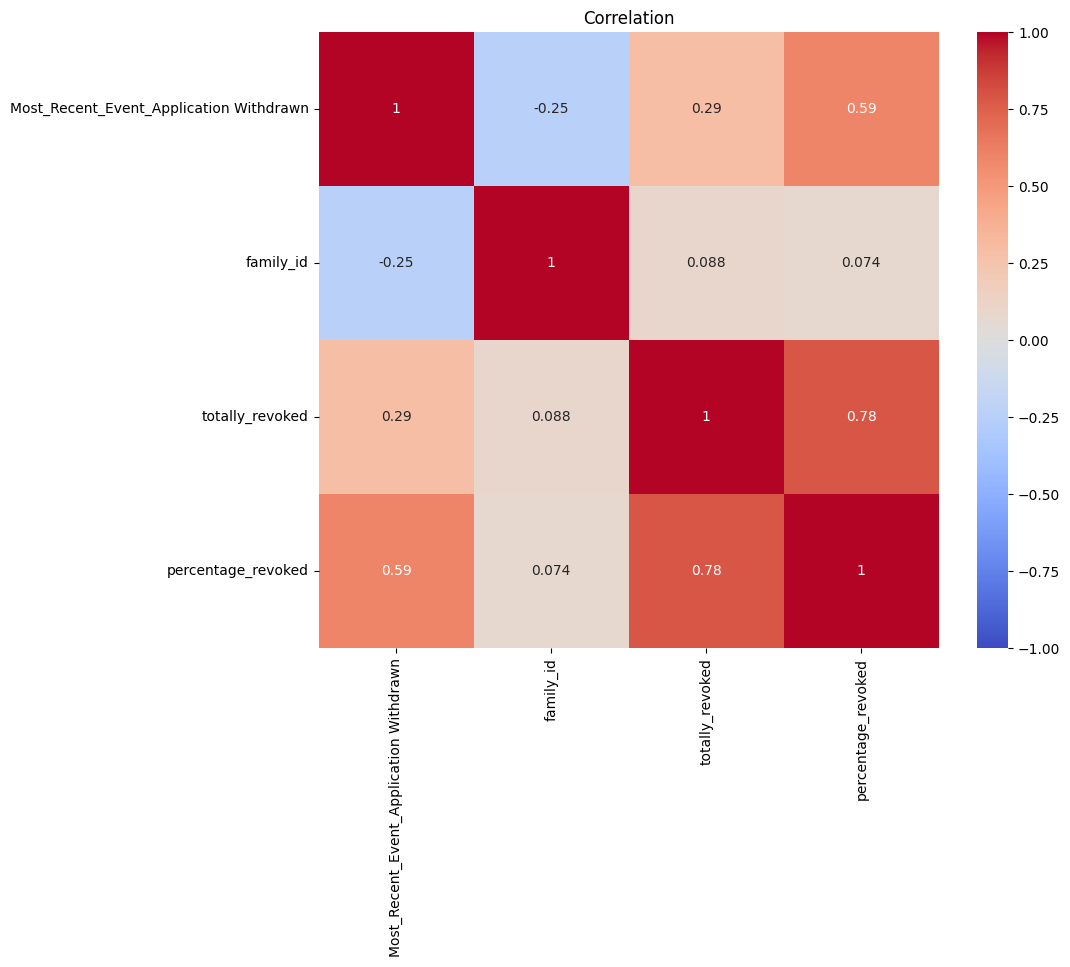

                                         Most_Recent_Event_Application Withdrawn  \
Most_Recent_Event_Application Withdrawn                                 1.000000   
family_id                                                              -0.246709   
totally_revoked                                                         0.291111   
percentage_revoked                                                      0.594246   

                                         family_id  totally_revoked  \
Most_Recent_Event_Application Withdrawn  -0.246709         0.291111   
family_id                                 1.000000         0.088150   
totally_revoked                           0.088150         1.000000   
percentage_revoked                        0.074259         0.783250   

                                         percentage_revoked  
Most_Recent_Event_Application Withdrawn            0.594246  
family_id                                          0.074259  
totally_revoked                      

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_analyze = ['Most_Recent_Event_Application Withdrawn', 'family_id', 'totally_revoked', 'percentage_revoked']

correlation_matrix = df[columns_to_analyze].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation')
plt.show()

print(correlation_matrix)

In [6]:
# We remove these highly correlated columns
df = df.drop(columns=['Most_Recent_Event_Application Withdrawn', 'family_id'])

In [7]:
# We extract the columns that contain year to know which one to use in the train/test
columnas_con_year = [col for col in df.columns if 'publication_date' in col.lower()]
df_filtrado = df[columnas_con_year]

In [8]:
df_filtrado

,Publication_Date_Min_year,Publication_Date_Min_month,Publication_Date_Min_quarter,Publication_Date_Min_semester,Publication_Date_Max_year,Publication_Date_Max_month,Publication_Date_Max_quarter,Publication_Date_Max_semester
0,1995,4,2,1,2002,1,1,1
1,1996,10,4,2,2002,12,4,2
2,1996,5,2,1,2004,3,1,1
3,1997,7,3,2,2002,6,2,1
4,2000,2,1,1,2004,12,4,2
...,...,...,...,...,...,...,...,...
60,2016,5,2,1,2023,7,3,2
61,2016,6,2,1,2022,1,1,1
62,2016,7,3,2,2024,4,2,1
63,2016,6,2,1,2019,6,2,1


In [9]:
df_filtrado['Publication_Date_Max_year'].unique()

array([2002, 2004, 2009, 2012, 2007, 2017, 2011, 2013, 2014, 2020, 2021,
       2022, 2015, 2019, 2023, 2018, 2016, 2024])

Publication_Date_Max_year is the year of the last date on which something happens for the patent family, i.e. when the parent application is modified.

To preserve the temporal structure of the data and avoid biases in our decision tree model, we will perform a temporal split. We will separate 70% of the data for training and the remaining 30% for testing. To ensure that the test set is representative of the most recent data, we will assign all records with 'Publication_Date_Max_year' in 2017,2016 & 2015 to the test set. This strategy will allow us to evaluate the model's performance on data that resembles what we would encounter in a real-world scenario.

In [10]:
count = df_filtrado['Publication_Date_Max_year'].value_counts()
count

,count
Publication_Date_Max_year,
2019,9
2020,8
2021,6
2023,5
2009,4
2012,4
2018,4
2017,4
2013,4


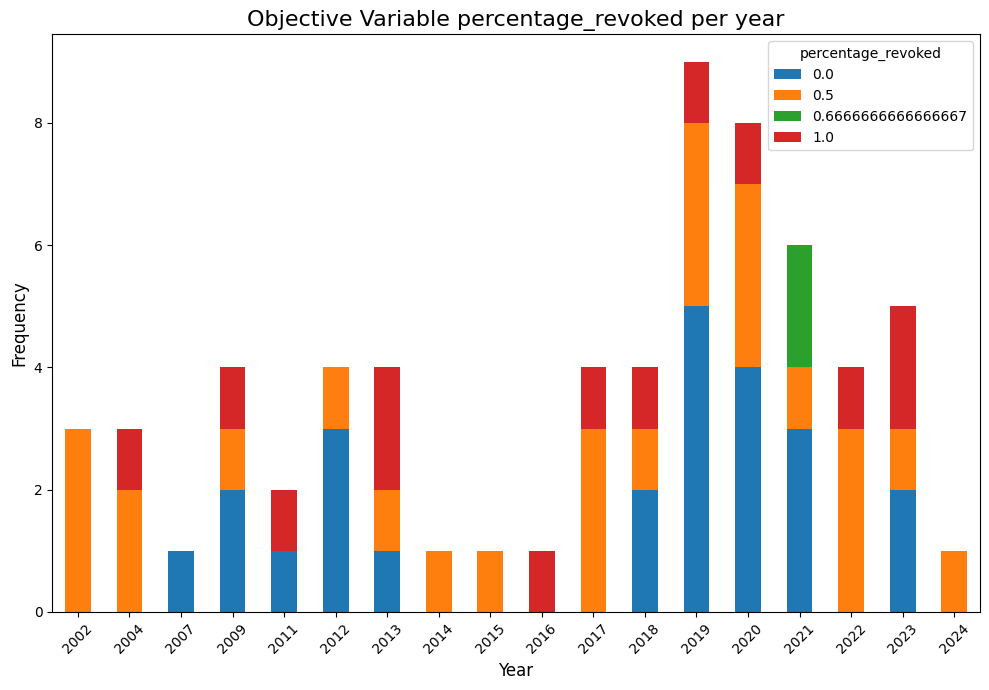

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

grouped_data = df.groupby(['Publication_Date_Max_year', 'percentage_revoked']).size().unstack(fill_value=0)

grouped_data.plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Objective Variable percentage_revoked per year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='percentage_revoked')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


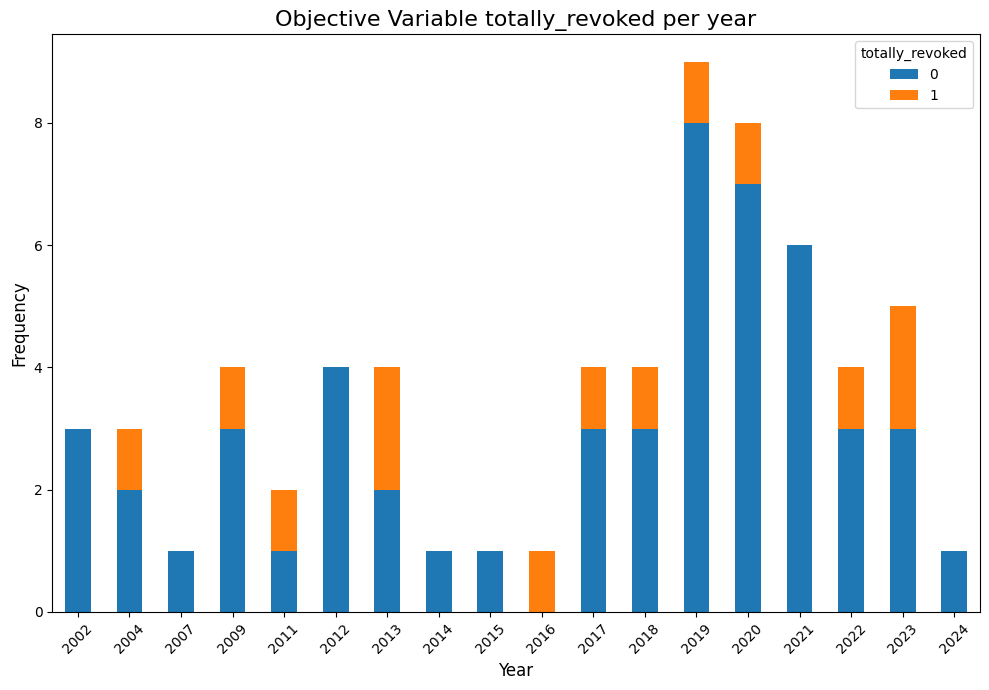

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

grouped_data = df.groupby(['Publication_Date_Max_year', 'totally_revoked']).size().unstack(fill_value=0)

grouped_data.plot(kind='bar', stacked=True, figsize=(10, 7))

plt.title('Objective Variable totally_revoked per year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='totally_revoked')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


[2024, 2023 & 2022] represents 30% of the patents families in which Most recent even occurs, so it is perfect for test split.

In [13]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Train split for years =< 2021, test for > 2021
df_train = df[~df['Publication_Date_Max_year'].isin([2024, 2023, 2022,2021])]
df_test = df[df['Publication_Date_Max_year'].isin([2024, 2023, 2022,2021])]

# Separate target characteristics and variables for training
X_train = df_train.drop(columns=['percentage_revoked', 'totally_revoked', 'Publication_Date_Max_year'])
y_train_reg = df_train['percentage_revoked']
y_train_clf = df_train['totally_revoked']

# Separate target characteristics and variables for testing
X_test = df_test.drop(columns=['percentage_revoked', 'totally_revoked', 'Publication_Date_Max_year'])
y_test_reg = df_test['percentage_revoked']
y_test_clf = df_test['totally_revoked']

# Create and train the regression decision tree
regressor = DecisionTreeRegressor(max_depth=10, random_state=42)
regressor.fit(X_train, y_train_reg)

# Creating and training the decision tree for classification
classifier = DecisionTreeClassifier(max_depth=10, random_state=42)
classifier.fit(X_train, y_train_clf)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [14]:
percent_train = (df_train.shape[0] / df.shape[0]) * 100
percent_train

75.38461538461539

In [15]:
count = df['percentage_revoked'].value_counts()
count

,count
percentage_revoked,
0.500000,26
0.000000,24
1.000000,13
0.666667,2


Calculate the MAE and el MSE for Decision Tree for Regression

In [16]:
# Predictions for regression
df_train.loc[:, 'yhat_reg'] = regressor.predict(X_train)
df_test.loc[:, 'yhat_reg'] = regressor.predict(X_test)

# Calculate MSE and MAE for regression
mse_train = mean_squared_error(y_train_reg, df_train['yhat_reg'])
mse_test = mean_squared_error(y_test_reg, df_test['yhat_reg'])
mae_train = mean_absolute_error(y_train_reg, df_train['yhat_reg'])
mae_test = mean_absolute_error(y_test_reg, df_test['yhat_reg'])

print(f"MSE Train: {mse_train}")
print(f"MSE Test: {mse_test}")
print(f"MAE Train: {mae_train}")
print(f"MAE Test: {mae_test}")

MSE Train: 0.0
MSE Test: 0.19618055555555555
MAE Train: 0.0
MAE Test: 0.28125


<ipython-input-16-bb7511da4039>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'yhat_reg'] = regressor.predict(X_train)
<ipython-input-16-bb7511da4039>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'yhat_reg'] = regressor.predict(X_test)


Overfitting: The fact that the MSE and MAE in the training set are 0.0 indicates that the regression tree fits the training data perfectly. This suggests that the model may be overfitting, capturing noise rather than generalizable patterns.

Performance on the Test Set: The MSE and MAE on the test set are higher, indicating that the model does not generalize as well to new data. The increase in error suggests that the model may be over-fitted to the training data and does not handle variability in unseen data well.

Graphic of prediction for Decision Tree for Regression

<ipython-input-17-359241bde911>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_train_reg.min(), y_train_reg.max()], [y_train_reg.min(), y_train_reg.max()], 'k--', lw=2, color='black')
<ipython-input-17-359241bde911>:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2, color='black')


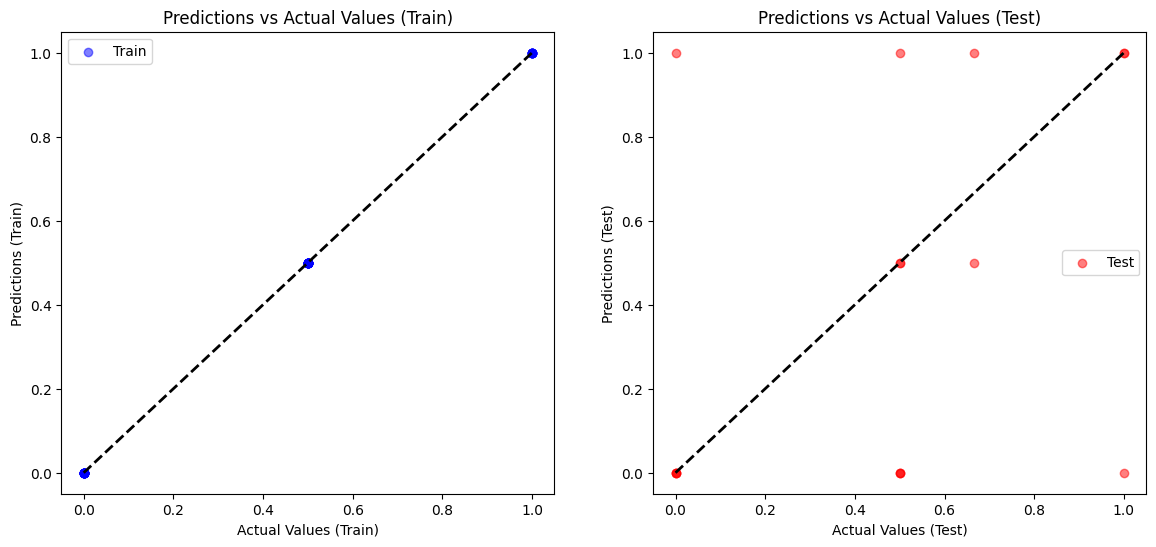

In [17]:
import matplotlib.pyplot as plt

# Plot predictions vs. actual values for training and testing
plt.figure(figsize=(14, 6))

# For training
plt.subplot(1, 2, 1)
plt.scatter(y_train_reg, regressor.predict(X_train), alpha=0.5, color='blue', label='Train')
plt.plot([y_train_reg.min(), y_train_reg.max()], [y_train_reg.min(), y_train_reg.max()], 'k--', lw=2, color='black')
plt.xlabel('Actual Values (Train)')
plt.ylabel('Predictions (Train)')
plt.title('Predictions vs Actual Values (Train)')
plt.legend()

# For testing
plt.subplot(1, 2, 2)
plt.scatter(y_test_reg, regressor.predict(X_test), alpha=0.5, color='red', label='Test')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2, color='black')
plt.xlabel('Actual Values (Test)')
plt.ylabel('Predictions (Test)')
plt.title('Predictions vs Actual Values (Test)')
plt.legend()

plt.show()



A higher color intensity indicates a higher density of predicted values in that area. The more distant and intense the color, the worse the prediction will be, since there are more predicted values in that area that are not correct.

As for the case of train, there are quite a few values with an intense color and close to the diagonal, which implies a better prediction accuracy.

While for the test, there are values that are also close and intense. But it is also true that there is a greater dispersion than in train, which indicates a decrease in performance with respect to train.

Calculate de AUC and Accuracy for Decesion Tree Classifier

In [18]:
# Calculate predictions
feature_names = X_train.columns.tolist()
df_train.loc[:, 'yhat_proba'] = classifier.predict_proba(df_train[feature_names])[:, 1]
df_test.loc[:, 'yhat_proba'] = classifier.predict_proba(df_test[feature_names])[:, 1]

# Calculate AUC
print(f"AUC Train: {roc_auc_score(y_train_clf, df_train['yhat_proba'])}")
print(f"AUC Test: {roc_auc_score(y_test_clf, df_test['yhat_proba'])}")

# Calculate Accuracy
print(f"Accuracy Train: {accuracy_score(y_train_clf, df_train['yhat_proba'] > 0.5)}")
print(f"Accuracy Test: {accuracy_score(y_test_clf, df_test['yhat_proba'] > 0.5)}")

AUC Train: 1.0
AUC Test: 0.6666666666666666
Accuracy Train: 1.0
Accuracy Test: 0.875


<ipython-input-18-d66eaa709d17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'yhat_proba'] = classifier.predict_proba(df_train[feature_names])[:, 1]
<ipython-input-18-d66eaa709d17>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'yhat_proba'] = classifier.predict_proba(df_test[feature_names])[:, 1]


##ROC Curve

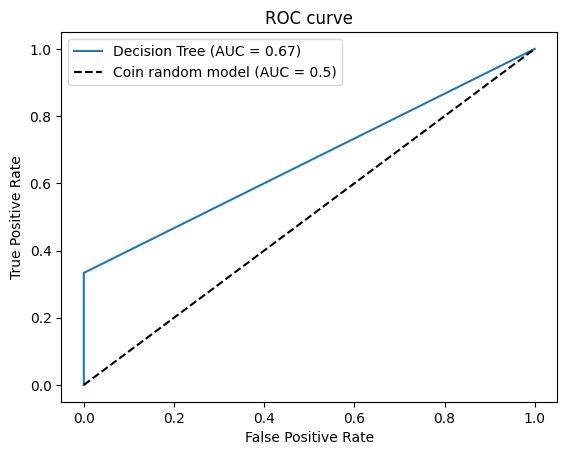

In [19]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test_clf, df_test.yhat_proba)

roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc,
    estimator_name='Decision Tree'
)
display.plot()

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], "k--", label="Coin random model (AUC = 0.5)")
plt.legend()

Graph Axes:
The X-axis represents the False Positive Rate (FPR). This value measures how many actual negatives were incorrectly classified as positive.

The Y-axis represents the True Positive Rate (TPR) or sensitivity, which measures how many true positives were correctly classified.

An AUC (Area Under the Curve) of 0.67 indicates that the Decision Tree model performs moderately well in distinguishing between the two classes.
The AUC can vary between 0.5 (random classification) and 1 (perfect classification). An AUC of 0.67 means that there is a 67% probability that the model correctly classifies a pair of points, one positive and one negative.


Performance Evaluation:
Since the model has an AUC of 0.67, this suggests that the model has modest performance and may need adjustment. There may be overfitting issues due to the large number of variables (1000) compared to the size of the data set (65 rows).

##Confusion matrix for Decision Tree for Classification

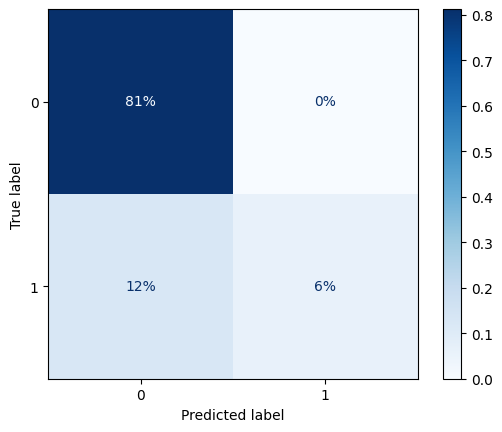

[[0.8125 0.    ]
 [0.125  0.0625]]


In [20]:
ConfusionMatrixDisplay.from_estimator(
    estimator=classifier,
    X=df_test[feature_names],
    y=y_test_clf,
    cmap=plt.cm.Blues,
    normalize='all',
    values_format='.0%'
)
plt.show()

# Create the confusion matrix
cm = confusion_matrix(y_test_clf, df_test['yhat_proba'] >= 0.5, normalize='all')
print(cm)


Here is the breakdown of the confusion matrix:

True Negatives (VN): 0.8125
False Positives (FP): 0.0
False Negatives (FN): 0.125
True Positive (VP): 0.0625


True Negatives (TN) - 0.8125

Description: Patents that are not revoked and the model correctly predicts that they are not revoked.
Implication: The high proportion of true negatives suggests that the model is good at identifying patents that are not at risk of revocation, which is positive as these cases are well classified and unnecessary concern is not generated.
False Positives (FP) - 0.0

Description: Patents that are not revoked but are predicted by the model to be revoked.
Implication: There are no false positives, which is excellent as no valid patents are being misclassified as revoked. This means that no false risk is being generated for patents that should not be of concern, avoiding unnecessary costs and paperwork.
False Negatives (FN) - 0.125

Description: Patents that are revoked but the model does not identify them as such.
Implication: The presence of false negatives indicates that some revoked patents are not detected by the model. This can be problematic because it could lead to the retention of patents that should be revised or deleted, affecting the integrity of the patent portfolio and possibly not complying with legal regulations.
True Positives (VP) - 0.0625

Description: Patents that are revoked and the model correctly identifies them as revoked.
Implication: Although there is a significant number of true positives, it is low compared to true negatives. This may imply that the model is not very effective in identifying revoked patents, which is critical because it can lead to the loss of relevant patents if they are not correctly identified.


The lack of false positives may be due to overfitting, as the tree generalizes the results.

##Representation of Decesion Tree

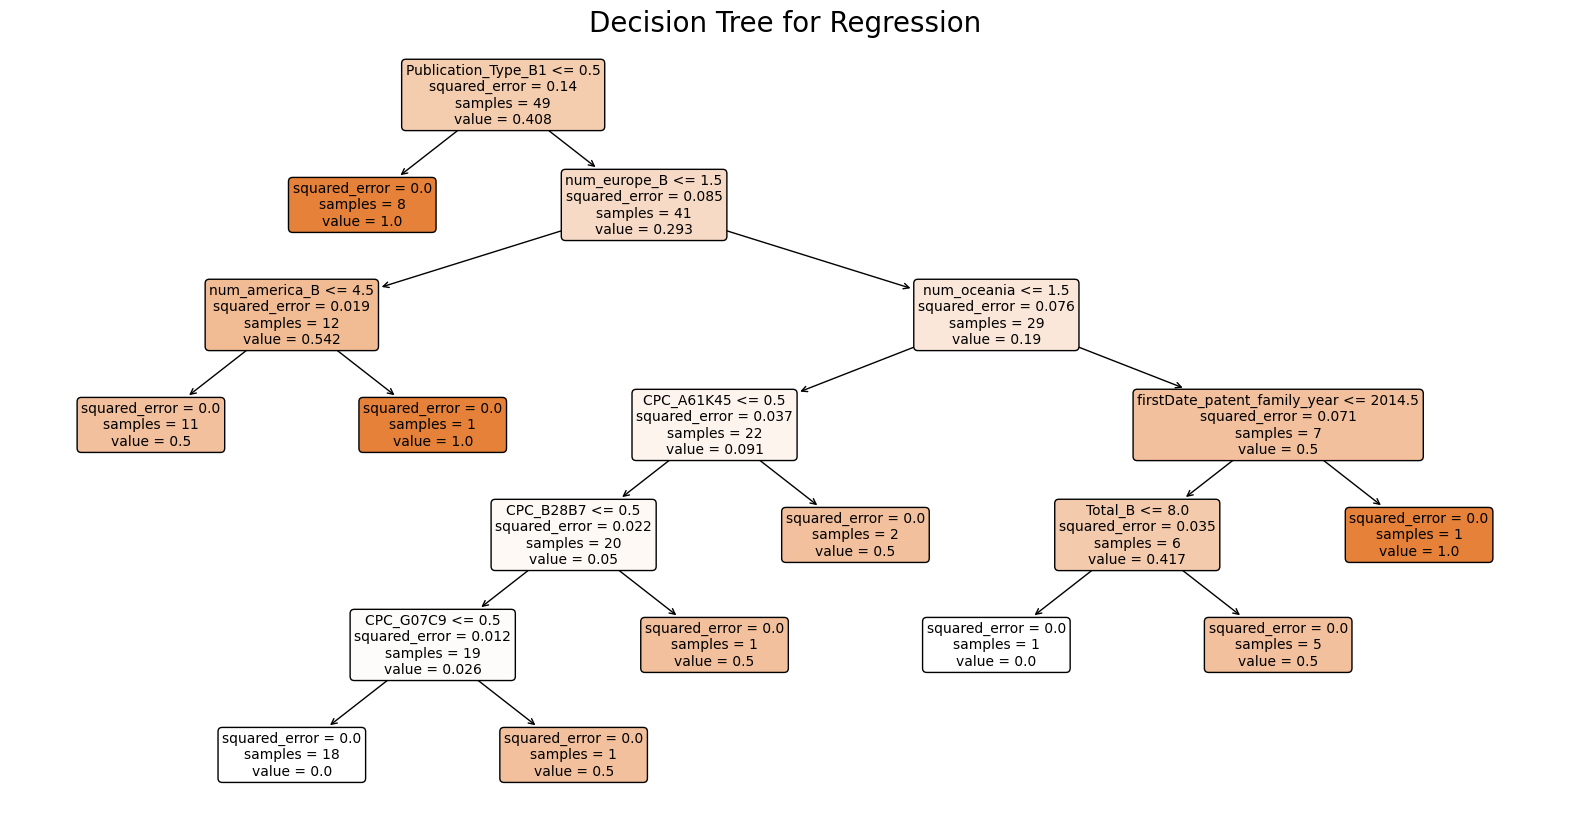

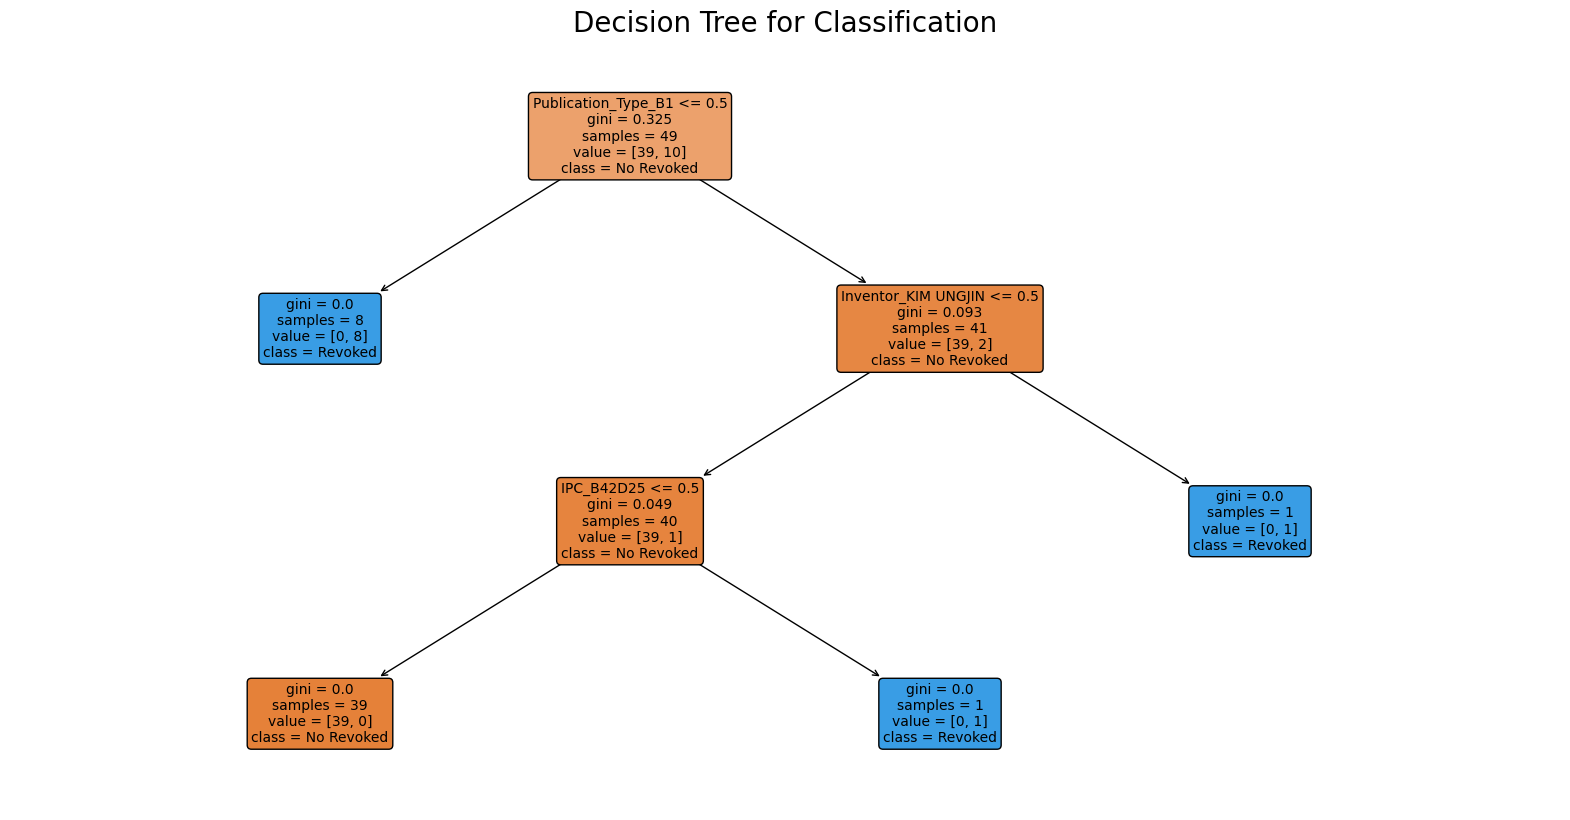

Depth of the regression tree: 6
Number of nodes in the regression tree: 10
Depth of the classification tree: 3
Number of nodes in the classification tree: 4

Importance of features for Regression:
1. Publication_Type_B1 (0.489843)
2. num_europe_B (0.153837)
3. num_oceania (0.129991)
4. CPC_A61K45 (0.053853)
5. firstDate_patent_family_year (0.042662)
6. CPC_G07C9 (0.034643)
7. num_america_B (0.033520)
8. CPC_B28B7 (0.031178)
9. Total_B (0.030473)
10. Representative_ALTMANN STÖSSEL DICK PATENTANWÄLTE PARTG MBB (0.000000)

Importance of features for Classification:
1. Publication_Type_B1 (0.760976)
2. IPC_B42D25 (0.122500)
3. Inventor_KIM UNGJIN (0.116524)
4. PatentFamily_Type_total (0.000000)
5. Representative_WIMMER HUBERT ET AL (0.000000)
6. Representative_HASELTINE LAKE KEMPNER LLP (0.000000)
7. Representative_MORRALL ROGER (0.000000)
8. Representative_KOHOL SONIA (0.000000)
9. Representative_ALTMANN STÖSSEL DICK PATENTANWÄLTE PARTG MBB (0.000000)
10. Representative_SIMON ELKE ANNA MA

In [21]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Tree display function
def visualize_tree(tree, feature_names, class_names=None, title=""):
    plt.figure(figsize=(20,10))
    plot_tree(tree,
              feature_names=feature_names,
              class_names=class_names,
              filled=True,
              rounded=True,
              fontsize=10)
    plt.title(title, fontsize=20)
    plt.show()

# Obtain feature names
feature_names = X_train.columns.tolist()

# Display the regression tree
visualize_tree(regressor, feature_names, title="Decision Tree for Regression")

# Display the classification tree
class_names = ['No Revoked', 'Revoked']
visualize_tree(classifier, feature_names, class_names, title="Decision Tree for Classification")

# Print additional information
print("Depth of the regression tree:", regressor.get_depth())
print("Number of nodes in the regression tree:", regressor.get_n_leaves())
print("Depth of the classification tree:", classifier.get_depth())
print("Number of nodes in the classification tree:", classifier.get_n_leaves())

# Print the most important characteristics for each tree
def print_feature_importance(tree, feature_names, title):
    importances = tree.feature_importances_
    indices = np.argsort(importances)[::-1]
    print(f"\nImportance of features for {title}:")
    for f in range(min(10, X_train.shape[1])):
        print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

print_feature_importance(regressor, feature_names, "Regression")
print_feature_importance(classifier, feature_names, "Classification")

##Convert tree schema to table

In [22]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.tree import _tree

# Function to extract the rules from the tree
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    paths = []
    path = []

    def recurse(node, depth, path):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            path.append(f"{name} <= {threshold}")
            recurse(tree_.children_left[node], depth + 1, path)
            path.pop()
            path.append(f"{name} > {threshold}")
            recurse(tree_.children_right[node], depth + 1, path)
            path.pop()
        else:
            path.append(f"class: {tree_.value[node]}")
            paths.append(list(path))
            path.pop()

    recurse(0, 1, path)
    return paths



##Decision Tree for Regression to Table

In [23]:
# Map the condictions and get final class one prediction
paths = tree_to_code(regressor, feature_names)
#paths = [p[:-1] + [ np.round(pd.to_numeric(p[-1].replace('class: [[','').replace(']]','').split(' ')[1]),2) ] for p in paths]

import numpy as np

# Adjust the processing of paths to handle the split case
paths = [
    p[:-1] + [
        np.round(
            pd.to_numeric(
                p[-1].replace('class: [[', '').replace(']]', '').split(' ')[1]
                if len(p[-1].replace('class: [[', '').replace(']]', '').split(' ')) > 1
                else p[-1].replace('class: [[', '').replace(']]', '')
            ), 2
        )
    ] for p in paths
]

max_depth = max(len(path) for path in paths)
columns = [f"Condition_{i+1}" for i in range(max_depth - 1)] + ["Prediction"]

df_rules = pd.DataFrame(paths, columns=columns)
#df_rules.to_clipboard(index=False)
df_rules

,Condition_1,Condition_2,Condition_3,Condition_4,Condition_5,Condition_6,Prediction
0,Publication_Type_B1 <= 0.5,1.0,None,None,None,None,NaN
1,Publication_Type_B1 > 0.5,num_europe_B <= 1.5,num_america_B <= 4.5,0.5,None,None,NaN
2,Publication_Type_B1 > 0.5,num_europe_B <= 1.5,num_america_B > 4.5,1.0,None,None,NaN
3,Publication_Type_B1 > 0.5,num_europe_B > 1.5,num_oceania <= 1.5,CPC_A61K45 <= 0.5,CPC_B28B7 <= 0.5,CPC_G07C9 <= 0.5,0.0
4,Publication_Type_B1 > 0.5,num_europe_B > 1.5,num_oceania <= 1.5,CPC_A61K45 <= 0.5,CPC_B28B7 <= 0.5,CPC_G07C9 > 0.5,0.5
5,Publication_Type_B1 > 0.5,num_europe_B > 1.5,num_oceania <= 1.5,CPC_A61K45 <= 0.5,CPC_B28B7 > 0.5,0.5,NaN
6,Publication_Type_B1 > 0.5,num_europe_B > 1.5,num_oceania <= 1.5,CPC_A61K45 > 0.5,0.5,None,NaN
7,Publication_Type_B1 > 0.5,num_europe_B > 1.5,num_oceania > 1.5,firstDate_patent_family_year <= 2014.5,Total_B <= 8.0,0.0,NaN
8,Publication_Type_B1 > 0.5,num_europe_B > 1.5,num_oceania > 1.5,firstDate_patent_family_year <= 2014.5,Total_B > 8.0,0.5,NaN
9,Publication_Type_B1 > 0.5,num_europe_B > 1.5,num_oceania > 1.5,firstDate_patent_family_year > 2014.5,1.0,None,NaN


##Decision Tree for Classification to Table

In [24]:
# Map the condictions and get final class one prediction
paths = tree_to_code(classifier, feature_names)
#paths = [p[:-1] + [ np.round(pd.to_numeric(p[-1].replace('class: [[','').replace(']]','').split(' ')[1]),2) ] for p in paths]

import numpy as np

# Adjust the processing of paths to handle the split case
paths = [
    p[:-1] + [
        np.round(
            pd.to_numeric(
                p[-1].replace('class: [[', '').replace(']]', '').split(' ')[1]
                if len(p[-1].replace('class: [[', '').replace(']]', '').split(' ')) > 1
                else p[-1].replace('class: [[', '').replace(']]', '')
            ), 2
        )
    ] for p in paths
]

max_depth = max(len(path) for path in paths)
columns = [f"Condition_{i+1}" for i in range(max_depth - 1)] + ["Prediction"]

df_rules = pd.DataFrame(paths, columns=columns)
#df_rules.to_clipboard(index=False)
df_rules

,Condition_1,Condition_2,Condition_3,Prediction
0,Publication_Type_B1 <= 0.5,8.0,None,NaN
1,Publication_Type_B1 > 0.5,Inventor_KIM UNGJIN <= 0.5,IPC_B42D25 <= 0.5,NaN
2,Publication_Type_B1 > 0.5,Inventor_KIM UNGJIN <= 0.5,IPC_B42D25 > 0.5,1.0
3,Publication_Type_B1 > 0.5,Inventor_KIM UNGJIN > 0.5,1.0,NaN


## **Second Aproach**

Since they are trees with very simple divisions, we are going to adjust parameters in the tree to arrive at variables that will help us to understand the behavior.

In [25]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Train split for years =< 2021, test for > 2021
df_train2 = df[~df['Publication_Date_Max_year'].isin([2024, 2023, 2022])]
df_test2 = df[df['Publication_Date_Max_year'].isin([2024, 2023, 2022])]

# Separate target characteristics and variables for training
X_train2 = df_train2.drop(columns=['percentage_revoked', 'totally_revoked', 'Publication_Date_Max_year'])
y_train_reg2 = df_train2['percentage_revoked']
y_train_clf2 = df_train2['totally_revoked']

# Separate target characteristics and variables for testing
X_test2 = df_test2.drop(columns=['percentage_revoked', 'totally_revoked', 'Publication_Date_Max_year'])
y_test_reg2 = df_test2['percentage_revoked']
y_test_clf2 = df_test2['totally_revoked']

# Create and train the regression decision tree
regressor2 = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=5,
    random_state=42
)
regressor2.fit(X_train2, y_train_reg2)

# Creating and training the decision tree for classification
classifier2 = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=5,
    random_state=42
)
classifier2.fit(X_train2, y_train_clf2)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42)

##Calculate de AUC and Accuracy for Decesion Tree Classifier

In [26]:
# Calculate predictions
feature_names2 = X_train2.columns.tolist()
df_train2.loc[:, 'yhat_proba'] = classifier2.predict_proba(df_train2[feature_names2])[:, 1]
df_test2.loc[:, 'yhat_proba'] = classifier2.predict_proba(df_test2[feature_names2])[:, 1]

# Calculate AUC
print(f"AUC Train: {roc_auc_score(y_train_clf2, df_train2['yhat_proba'])}")
print(f"AUC Test: {roc_auc_score(y_test_clf2, df_test2['yhat_proba'])}")

# Calculate Accuracy
print(f"Accuracy Train: {accuracy_score(y_train_clf2, df_train2['yhat_proba'] > 0.5)}")
print(f"Accuracy Test: {accuracy_score(y_test_clf2, df_test2['yhat_proba'] > 0.5)}")

AUC Train: 0.9933333333333334
AUC Test: 0.6190476190476191
Accuracy Train: 0.9636363636363636
Accuracy Test: 0.8


<ipython-input-26-db40934784f9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2.loc[:, 'yhat_proba'] = classifier2.predict_proba(df_train2[feature_names2])[:, 1]
<ipython-input-26-db40934784f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test2.loc[:, 'yhat_proba'] = classifier2.predict_proba(df_test2[feature_names2])[:, 1]


The Decision Tree Classifier results indicate a possible overfitting. The AUC on the training set is very high (0.993), suggesting that the model fits these data almost perfectly. However, the AUC on the test set is significantly lower (0.667), indicating poor performance when generalizing to unseen data. Although the training accuracy is high (0.964) and the test accuracy is still acceptable (0.8), **the difference in the AUC reflects that the model is overfitting the training data and does not generalize well.**

##Calculate the MAE and el MSE for Decision Tree for Regression

In [27]:
# Predictions for regression
df_train2.loc[:, 'yhat_reg'] = regressor2.predict(X_train2)
df_test2.loc[:, 'yhat_reg'] = regressor2.predict(X_test2)

# Calculate MSE and MAE for regression
mse_train2 = mean_squared_error(y_train_reg2, df_train2['yhat_reg'])
mse_test2 = mean_squared_error(y_test_reg2, df_test2['yhat_reg'])
mae_train2 = mean_absolute_error(y_train_reg2, df_train2['yhat_reg'])
mae_test2 = mean_absolute_error(y_test_reg2, df_test2['yhat_reg'])

print(f"MSE Train: {mse_train2}")
print(f"MSE Test: {mse_test2}")
print(f"MAE Train: {mae_train2}")
print(f"MAE Test: {mae_test2}")

MSE Train: 0.032159090909090915
MSE Test: 0.18203125
MAE Train: 0.10363636363636364
MAE Test: 0.2833333333333333


<ipython-input-27-f84bcff0d25c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train2.loc[:, 'yhat_reg'] = regressor2.predict(X_train2)
<ipython-input-27-f84bcff0d25c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test2.loc[:, 'yhat_reg'] = regressor2.predict(X_test2)


The Decision Tree for Regression results show signs of overfitting, as the MSE in the training set is low (0.030), while in the test set it is significantly higher (0.119), indicating worse generalization performance. Similarly, the MAE is low in training (0.091), but increases significantly in the test set (0.268). **This suggests that the model fits the training data well, but loses accuracy when confronted with unseen data, indicating that it is overfitting.**

We have adjusted the hyperparameters of the decision trees, but we have obtained a slightly lower performance in terms of the evaluation metrics of the first trees created. This may be due to the scarcity of data, since we have few patents, so the model tends to learn patterns and generalize predictions.

This is why we kept the first regression and classification tree, and then applied them to models with the most significant variables obtained from these trees.

# **Important features to the Model of Regression**

Once we have performed the tests for both regression and classification decision trees, we are going to select the best variables from the first approach which was the most favorable. We choose the 5 best variables to create a logistic regression and a linear regression.

In [28]:
# Obtener la importancia de las características para el árbol de regresión
importance_features_reg = pd.Series(regressor.feature_importances_, index=X_test.columns)
importance_features_reg = importance_features_reg.sort_values(ascending=False)
print("Feature importance for regression tree:")
print(importance_features_reg)

# Obtain the importance of the features for the classification tree.
importance_features_class = pd.Series(classifier.feature_importances_, index=X_test.columns)
importance_features_class = importance_features_class.sort_values(ascending=False)
print("Feature importance for classification tree:")
print(importance_features_class)


Feature importance for regression tree:
Publication_Type_B1                                  0.489843
num_europe_B                                         0.153837
num_oceania                                          0.129991
CPC_A61K45                                           0.053853
firstDate_patent_family_year                         0.042662
                                                       ...   
Representative_DERKS WILBERT ET AL                   0.000000
Representative_VO                                    0.000000
Representative_MANITZ FINSTERWALD AMP PARTNER GBR    0.000000
Representative_LANZONI LUCIANO                       0.000000
PatentFamily_Type_total                              0.000000
Length: 1074, dtype: float64
Feature importance for classification tree:
Publication_Type_B1                                                               0.760976
IPC_B42D25                                                                        0.122500
Inventor_KIM UNGJIN    

In [29]:
# Selecting the most important features (top 5) for the regression model
top_features_reg = importance_features_reg.head(5).index.tolist()
print(top_features_reg)
# Selecting the most important features (top 5) for the classification model
top_features_class = importance_features_class.head(5).index.tolist()
print(top_features_class)

['Publication_Type_B1', 'num_europe_B', 'num_oceania', 'CPC_A61K45', 'firstDate_patent_family_year']
['Publication_Type_B1', 'IPC_B42D25', 'Inventor_KIM UNGJIN', 'Total_A', 'CPC_C08F265']


In [30]:
# Añadir la tasa de éxito por continentes a la lista de características más importantes para el modelo de regresión
top_features_reg.extend([
    "patent_family_success_rate_europe",
    "patent_family_success_rate_america",
    "patent_family_success_rate_asia",
    "patent_family_success_rate_africa",
    "patent_family_success_rate_oceania"
])

# Añadir la tasa de éxito por continentes a la lista de características más importantes para el modelo de clasificación
top_features_class.extend([
    "patent_family_success_rate_europe",
    "patent_family_success_rate_america",
    "patent_family_success_rate_asia",
    "patent_family_success_rate_africa",
    "patent_family_success_rate_oceania"
])

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

# Preparing data for linear regression
X_reg = df[top_features_reg]
y_reg = df['percentage_revoked']

# Preparing data for logistic regression
X_class = df[top_features_class]
y_class = df['totally_revoked']

# Splitting data into training and test sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Linear regression model for the continuous variable
lin_reg = LinearRegression()
lin_reg.fit(X_reg_train, y_reg_train)
y_reg_pred = lin_reg.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_reg_pred)

log_reg = LogisticRegression()
log_reg.fit(X_class_train, y_class_train)
y_class_pred = log_reg.predict(X_class_test)
y_class_pred = log_reg.predict(X_class_test)
y_reg_pred = lin_reg.predict(X_reg_test)


##Linear Regression

In [32]:
print(f"Mean square error for linear regression:{mse}")
print("--------------------------------------------")
# Linear regression model coefficients
print("Linear regression model coefficients:")

for feature, coef in zip(top_features_reg, lin_reg.coef_):
    print(f"{feature}: {coef}")

# Intercept of the linear regression model
print(f"Intercepto (b0): {lin_reg.intercept_}")

Mean square error for linear regression:0.059809136177738725
--------------------------------------------
Linear regression model coefficients:
Publication_Type_B1: -0.34397834038216824
num_europe_B: -0.09678220832456491
num_oceania: 0.06407022683319
CPC_A61K45: 0.1833555791595211
firstDate_patent_family_year: -0.0009955589228124867
patent_family_success_rate_europe: -0.2906385551273355
patent_family_success_rate_america: -0.06631960364083928
patent_family_success_rate_asia: 0.07399979561710394
patent_family_success_rate_africa: 0.0
patent_family_success_rate_oceania: -0.05835787047035529
Intercepto (b0): 2.966289016852025


##Evaluation of linear regression metrics

In [33]:
# Calculation of metrics
r2 = r2_score(y_reg_test, y_reg_pred)
mae = mean_absolute_error(y_reg_test, y_reg_pred)
mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)

print(f"R² (Determination Coefficient): {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

R² (Determination Coefficient): 0.65
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.24


R² (Coefficient of Determination): 0.67

Interpretation: The model explains 67% of the variability in the dependent variable. This suggests that the model has a moderate ability to capture variation in the data. A value of 1 would indicate perfect prediction, while a value of 0 would indicate that the model explains none of the variability.


Mean Absolute Error (MAE): 0.19.

Interpretation: The MAE measures the average of the absolute errors of the predictions. In this case, the model has an average error of 0.19 units. It is an intuitive metric that shows, on average, how much the model predictions deviate from the actual values.

Mean Squared Error (MSE): 0.06.

Interpretation: The MSE measures the average of the squared errors. An MSE of 0.06 indicates that the model has relatively small mean squared errors. MSE penalizes larger errors more than MAE, meaning that if there are some predictions with very large errors, MSE will reflect this more than MAE.

Root Mean Squared Error (RMSE): 0.24.

Interpretation: The RMSE is the square root of the MSE and provides a measure of the error in the same units as the dependent variable. An RMSE of 0.24 means that, on average, the model deviates by 0.24 units from the true values. Like the MSE, the RMSE penalizes large errors more than the MAE.

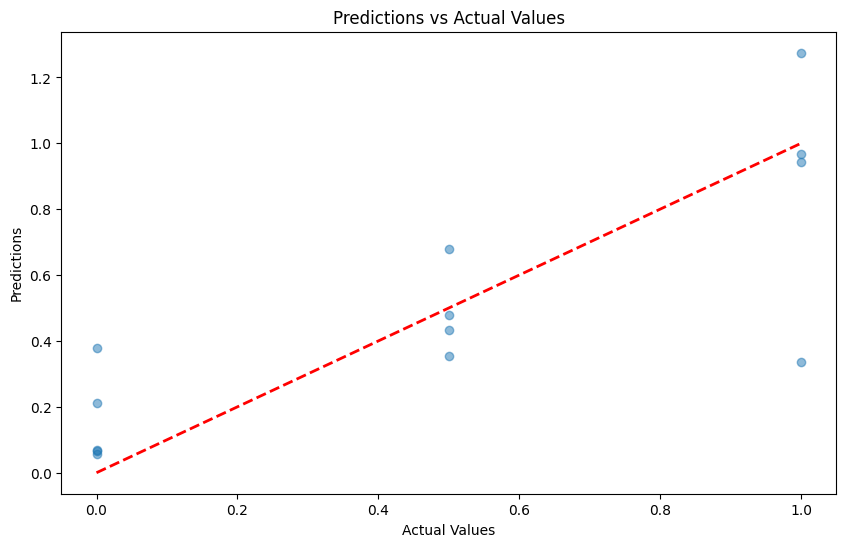

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_reg_test, y_reg_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Values')
plt.show()


There are some points that are close to the line, indicating reasonable predictions.

However, there appear to be several points away from the line, suggesting that the model has considerable errors for some values.
Clustering at the extremes: It can be seen that the points are clustered at certain values of the predictions, which could indicate that the model is having difficulty predicting intermediate values and may be biased toward low or high values.

Overall, the graph suggests that **the model has noticeable errors**, **especially at the extreme values**, indicating that it is not completely accurate in predicting some values.

In [35]:
residuals = y_reg_test - y_reg_pred

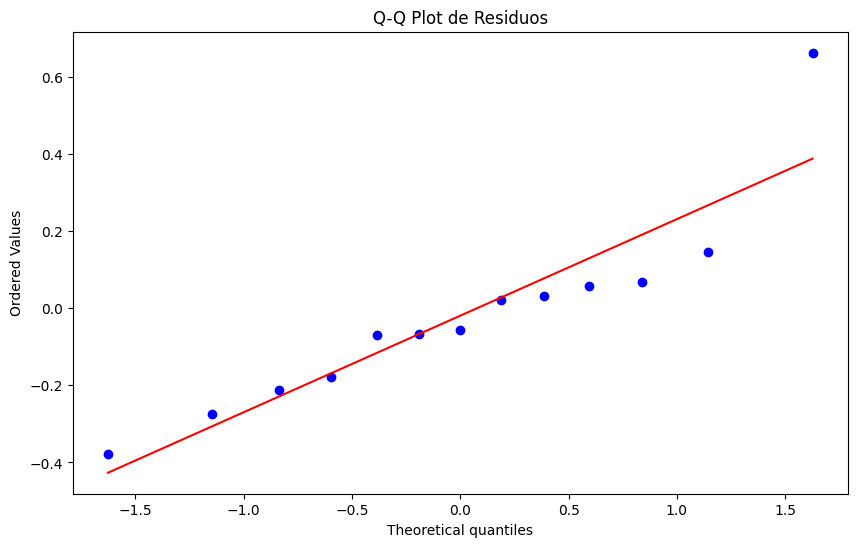

In [36]:
import scipy.stats as stats

plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos')
plt.show()


If the points roughly follow the red line, it indicates that the residuals are normally distributed.

In this plot, the points are mostly aligned with the red line, suggesting that the residuals behave close to normal, although there are some slight deviations at the extremes (lower and higher quantiles), which is common.


Overall, it appears that the **residuals follow a reasonable normal distribution**, which is a good **sign for the validity of the regression** model. However, the **slight deviations at the extremes could indicate the presence of outliers** or a problem of heteroscedasticity in certain ranges.

##Logistic Regresion

In [37]:
# Logistic regression model for the binary variable
accuracy = accuracy_score(y_class_test, y_class_pred)
print(f"Accuracy for logistic regression: {accuracy}")
print("--------------------------------------------")
# Coefficients of the logistic regression model
print("Coefficients of the logistic regression model:")
for feature, coef in zip(top_features_class, log_reg.coef_[0]):
    print(f"{feature}: {coef}")

# Intercept of the logistic regression model
print(f"Intercept (b0): {log_reg.intercept_}")

Accuracy for logistic regression: 0.9230769230769231
--------------------------------------------
Coefficients of the logistic regression model:
Publication_Type_B1: -2.3132012179966464
IPC_B42D25: 0.7447881310407938
Inventor_KIM UNGJIN: 0.8049682431190007
Total_A: -0.01265450573985731
CPC_C08F265: -0.11898302430534494
patent_family_success_rate_europe: -0.5459851826977603
patent_family_success_rate_america: -0.042666722779446345
patent_family_success_rate_asia: -0.08250297162917622
patent_family_success_rate_africa: 0.0
patent_family_success_rate_oceania: 0.4994592438374732
Intercept (b0): [0.58924794]


##Evaluation of logistic regression metrics:

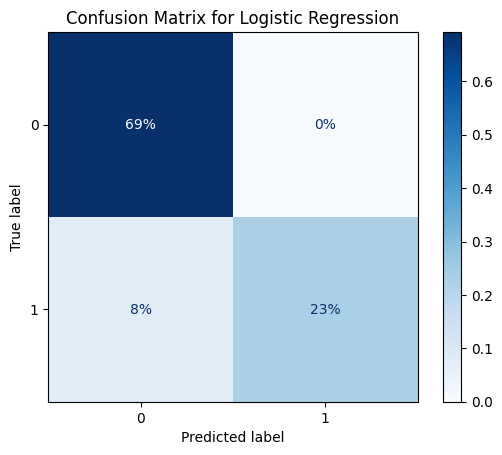

In [38]:
# Generate the confusion matrix
cm = confusion_matrix(y_class_test, y_class_pred, normalize='all')

# Display the confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_reg.classes_).plot(cmap=plt.cm.Blues, values_format='.0%')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


The matrix indicates that the model made 9 correct predictions for the negative class, 0 incorrect predictions for the positive class (i.e. no false positives), 1 incorrect prediction for the negative class and 3 correct predictions for the positive class.

Accuracy: 0.92.

Interpretation: The model correctly predicted 92% of the instances. This is very high, suggesting that the model performs well overall. Although it is also true that **overfitting is very present**.

Precision: 1.00
Interpretation: When the model predicts the positive class, it does so correctly 100% of the time. There are no false positives, which is excellent.
Recall: 0.75

Interpretation: The model identified 75% of the true positive cases. There are 25% false negatives, which means that the model** missed some positive cases**.
F1-Score: 0.86

Interpretation: The F1-Score is a harmonic mean between precision and recall. A value of 0.86 indicates a good balance between these two aspects, considering that the model **has high precision and moderate recall**.


AUC (Area Under the ROC curve): 0.97
Interpretation: An AUC of 0.97 is excellent, indicating that the model has a high ability to distinguish between positive and negative classes. A value close to 1 suggests outstanding performance.
In summary, the logistic regression model appears to be performing very well, with high accuracy and excellent ability to discriminate between classes. The recall could be improved somewhat to ensure that more true positive cases are identified.

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Definir el modelo de regresión logística
log_reg_1 = LogisticRegression(solver='liblinear')  # Usar 'liblinear' para L1 y L2

# Definir la cuadrícula de hiperparámetros para la búsqueda en cuadrícula
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 20, 50]  # Incluir valores más pequeños
}


# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=log_reg_1, param_grid=param_grid, cv=5, scoring='accuracy')

# Ajustar el modelo con la búsqueda en cuadrícula
grid_search.fit(X_class_train, y_class_train)

# Obtener los mejores hiperparámetros
print("Best parameters found: ", grid_search.best_params_)

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_class_pred = best_model.predict(X_class_test)

# Calcular las métricas de rendimiento
accuracy = accuracy_score(y_class_test, y_class_pred)
precision = precision_score(y_class_test, y_class_pred)
recall = recall_score(y_class_test, y_class_pred)
f1 = f1_score(y_class_test, y_class_pred)
roc_auc = roc_auc_score(y_class_test, best_model.decision_function(X_class_test))

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))
print("AUC: {:.2f}".format(roc_auc))


Best parameters found:  {'C': 10, 'penalty': 'l2'}
Accuracy: 0.92
Precision: 1.00
Recall: 0.75
F1-Score: 0.86
AUC: 1.00


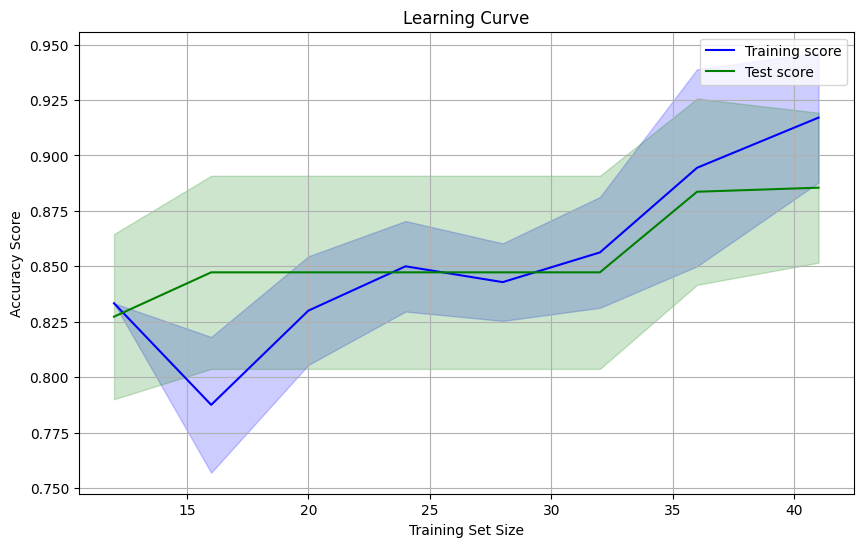

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Obtener las curvas de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(log_reg_1, X_class_train, y_class_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calcular las medias y las desviaciones estándar para las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="blue", alpha=0.2)

plt.plot(train_sizes, test_scores_mean, label="Test score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="green", alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()







Key observations:

Performance on the training set:
The blue line is quite high and close to 1.0 (100% accuracy), suggesting that the model fits the training data very well (almost perfectly).

However, this can also be a sign of overfitting, as the model may be learning the training data too well and not generalizing well to the test data.
Performance on the test/validation set:
The green line shows more irregular behavior, indicating that the accuracy on the test set varies and is significantly lower than on the training set.

The fact that the accuracy on the validation/test set does not stay as high as on the training set, and that it varies considerably as the training set sizes change, suggests that the model is not generalizing well and is probably overfitting.

Difference between the curves:
There is a clear gap between the performance on the training set (blue curve) and on the validation set (green curve).
This gap is a typical sign of overfitting, as the model performs much better on the training data than on the validation data.

Variability in the test curve:
The green shaded area around the validation curve shows high variability, meaning that the model's performance on the test data is unstable and could depend on the subset of the training size used.

This could indicate that the model is sensitive to changes in the data and that a larger or more representative dataset could help stabilize its performance.

Conclusion:
The model appears overfitted to the training data, which is evidenced by the high accuracy in training and the less consistent performance on the validation set.

##Weights and equations of the models:

In [41]:
print(f"Mean square error for linear regression:{mse}")
print("--------------------------------------------")
# Linear regression model coefficients
print("Linear regression model coefficients:")

for feature, coef in zip(top_features_reg, lin_reg.coef_):
    print(f"{feature}: {coef}")

# Intercept of the linear regression model
print(f"Intercepto (b0): {lin_reg.intercept_}")

Mean square error for linear regression:0.059809136177738725
--------------------------------------------
Linear regression model coefficients:
Publication_Type_B1: -0.34397834038216824
num_europe_B: -0.09678220832456491
num_oceania: 0.06407022683319
CPC_A61K45: 0.1833555791595211
firstDate_patent_family_year: -0.0009955589228124867
patent_family_success_rate_europe: -0.2906385551273355
patent_family_success_rate_america: -0.06631960364083928
patent_family_success_rate_asia: 0.07399979561710394
patent_family_success_rate_africa: 0.0
patent_family_success_rate_oceania: -0.05835787047035529
Intercepto (b0): 2.966289016852025


The linear regression formula is:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n
$$
Donde:

- y es la predicción (en este caso, la probabilidad de revocación de patentes),
- beta_0  es el intercepto del modelo,
- beta_1, beta_2, dots, beta_n  son los coeficientes de las variables,
- X_1, X_2, dots, X_n son los valores de las variables independientes.


$$
y = 2.96628902 - 0.34397834 \cdot X_{\text{Publication_Type_B1}} - 0.09678221 \cdot X_{\text{num_europe_B}} + 0.06407023 \cdot X_{\text{num_oceania}} + 0.18335558 \cdot X_{\text{CPC_A61K45}} - 0.00099556 \cdot X_{\text{firstDate_patent_family_year}} - 0.29063856 \cdot X_{\text{patent_family_success_rate_europe}} - 0.06631960 \cdot X_{\text{patent_family_success_rate_america}} + 0.07399980 \cdot X_{\text{patent_family_success_rate_asia}} + 0.0 \cdot X_{\text{patent_family_success_rate_africa}} - 0.05835787 \cdot X_{\text{patent_family_success_rate_oceania}}
$$

In [42]:
# Logistic regression model for the binary variable
accuracy = accuracy_score(y_class_test, y_class_pred)
print(f"Accuracy for logistic regression: {accuracy}")
print("--------------------------------------------")
# Coefficients of the logistic regression model
print("Coefficients of the logistic regression model:")
for feature, coef in zip(top_features_class, log_reg.coef_[0]):
    print(f"{feature}: {coef}")

# Intercept of the logistic regression model
print(f"Intercept (b0): {log_reg.intercept_}")

Accuracy for logistic regression: 0.9230769230769231
--------------------------------------------
Coefficients of the logistic regression model:
Publication_Type_B1: -2.3132012179966464
IPC_B42D25: 0.7447881310407938
Inventor_KIM UNGJIN: 0.8049682431190007
Total_A: -0.01265450573985731
CPC_C08F265: -0.11898302430534494
patent_family_success_rate_europe: -0.5459851826977603
patent_family_success_rate_america: -0.042666722779446345
patent_family_success_rate_asia: -0.08250297162917622
patent_family_success_rate_africa: 0.0
patent_family_success_rate_oceania: 0.4994592438374732
Intercept (b0): [0.58924794]


The general formula for the logistic regression model is:

$$
P(y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n)}}
$$

Where:

- P(y=1|X) is the probability that event \( y \) occurs given a set of characteristics \( X \).
- beta_0 is the intercept of the model (also known as the constant term).
- beta_1, beta_2, dots, beta_n are the coefficients of the independent variables.
- X_1, X_2, dots, X_n are the values ​​of the independent variables.

$$
P(y=1|X) = \frac{1}{1 + e^{-\left(0.58924794 - 2.31320122 \cdot X_{\text{Publication_Type_B1}} + 0.74478813 \cdot X_{\text{IPC_B42D25}} + 0.80496824 \cdot X_{\text{Inventor_KIM_UNGJIN}} - 0.01265451 \cdot X_{\text{Total_A}} - 0.11898302 \cdot X_{\text{CPC_C08F265}} - 0.54598518 \cdot X_{\text{patent_family_success_rate_europe}} - 0.04266672 \cdot X_{\text{patent_family_success_rate_america}} - 0.08250297 \cdot X_{\text{patent_family_success_rate_asia}} + 0.0 \cdot X_{\text{patent_family_success_rate_africa}} + 0.49945924 \cdot X_{\text{patent_family_success_rate_oceania}}\right)}}
$$

## Conclusions

**Linear regression**

- Publication Type (Publication_Type_B1):
In the patent world, the publication type "B1" refers to a patent published after a complete process. This type of patent reflects a higher level of validity and maturity in its process.

- Number of Patents in Europe (num_europe_B):
This variable measures the number of type B publications in Europe, i.e. patents that have been granted within a patent family in Europe. A higher number of type B publications reflects a legal success in the patent granting process in this region.

- Number of Patents in Oceania (num_oceania_A):
Represents the number of patents issued in the Oceania region. This region may have unique characteristics regarding patent protection and administration.

- CPC Classification A61K45 (CPC_A61K45):
Refers to a particular classification of patents in the area of ​​compositions for pharmaceutical products. This type of classification may reflect innovation in the field of medicine and biotechnology.

- Patent Family First Publication Date (firstDate_patent_family_year):
This variable reflects the year in which a patent within a patent family was first published. Older patents may have had more time to face legal or regulatory challenges.

- Patent Family Success Rate in Europe (patent_family_success_rate_europe):
Measures the success rate of patent families in Europe, which may reflect the robustness and protection of patents on that continent.

- Patent Family Success Rate in America (patent_family_success_rate_america):
This indicator measures the success of patent families in the Americas. A higher success rate in this region could be related to stronger protection systems.

- Patent Family Success Rate in Asia (patent_family_success_rate_asia):
Reflects the success rate of patent families in Asia, a region that has seen rapid growth in patent activity.

- Patent Family Success Rate in Oceania (patent_family_success_rate_oceania):
This indicator measures the success rate of patent families in Oceania. A higher rate may mean greater patent stability or protection in this region.

**Storytelling**
- Publication Type (Publication_Type_B1):
Imagine that we are looking at a patent that has gone through the full examination process and has been published as a type B1 patent. According to the model, patents of this type are less likely to be revoked. The coefficient of -0.344 indicates a reduction in the probability of revocation by 34.40%, suggesting that type B1 patents are more stable and less likely to face revocations.

- Number of Granted Publications in Europe (num_europe_B):
Let us now consider the number of type B publications in Europe, i.e. patents that have been granted within a patent family in Europe. Our model suggests that as the number of these patents granted in Europe increases, the probability of a patent being revoked decreases. The coefficient of -0.097 implies a slight reduction in the probability of revocation by 9.68%, which could reflect the idea that more patents are granted in Europe.

- Number of Patents in Oceania (num_oceania):
Regarding the patents granted in the Oceania region, the model suggests that as the number of these patents increases, the probability of revocation also grows slightly. With a coefficient of 0.064, the model predicts an increase in the probability of revocation by 6.41% for each additional patent in this region. This could be due to increased complexity in Oceania's legal systems or specific challenges in patent management.

- CPC Classification A61K45 (CPC_A61K45):
For a pharmaceutical-related patent (classification A61K45), our model indicates that patents in this area are more likely to face revocation, with a coefficient of 0.183 suggesting an increase in the probability of revocation by 18.34%. Pharmaceutical patents, often subject to strict regulations and competition, may face more legal challenges.

- First Publication Date of Patent Family (firstDate_patent_family_year):
Older patents, according to the model, are slightly less likely to be revoked as time passes. The coefficient of -0.001 suggests a 0.10% reduction in the probability of revocation for each year that passes since first publication. This could indicate that patents that have survived longer in the system are less likely to face revocations.

- Patent Family Success Rate in Europe (patent_family_success_rate_europe):
In Europe, patent family success appears to be associated with a decrease in patent revocation. A coefficient of -0.291 indicates a 29.06% reduction in revocation risk. This suggests that patents that achieve greater stability in Europe face less legal risk.

- Patent Family Success Rate in America (patent_family_success_rate_america):
Similarly, patent success in America shows a small reduction in revocation risk, with a decrease of 6.63% (coefficient of -0.066). This could reflect a more robust patent system and more effective protection in the region.

- Patent Family Success Rate in Asia (patent_family_success_rate_asia):
On the other hand, in Asia, an increase in the patent success rate appears to be associated with an increase in the probability of revocation. The coefficient of 0.074 indicates a 7.40% increase in the probability of revocation, which could suggest that successful patents in this region are more exposed to legal challenges or disputes.

- Patent Family Success Rate in Oceania (patent_family_success_rate_oceania):
Finally, in Oceania, an increase in the success rate of a patent family is related to a higher probability of revocation. With a coefficient of -0.058, the model shows a 5.84% decrease in the probability of revocation, reflecting that even if a patent is successful in this region, it is not necessarily free from legal challenges.


# **Logistic Regresion**

## **Conclusions**
**Logistic regression**

- Publication_Type_B1: In the patent world, publication type "B1" refers to a patent that has gone through the entire examination process and has been published. This patent type reflects greater validation and maturity in the granting process.

- IPC_B42D25: The IPC_B42D25 classification falls under section "B" of the patent classification, which covers general industrial techniques. This specific classification relates to printing, binding, and record storage operations. This variable may influence the likelihood of patent revocation due to the specific technological domain it represents.

- Inventor_KIM UNGJIN: Patents associated with inventor KIM UNGJIN are highly involved in fields like hydrogel, material science, and chemical engineering, which might contribute to higher complexity and challenges, leading to an increased risk of revocation.

- Total_A: This variable represents the total number of publications within a patent family, including both application records (A) and granted patents (B). A higher total number of publications within a patent family may influence the likelihood of revocation.

- CPC_C08F265: This CPC classification refers to macromolecular compounds obtained from reactions involving only unsaturated carbon-to-carbon bonds, in the field of organic chemistry. This variable may be associated with a specific technology or area of ​​innovation in chemistry.

- Patent Family Success Rate in Europe (patent_family_success_rate_europe): Measures the success rate of patent families in Europe, reflecting the robustness and protection of patents in that region.

- Patent Family Success Rate in America (patent_family_success_rate_america): Measures the success rate of patent families in America, indicating the stability and protection of patents in that region.

- Patent Family Success Rate in Asia (patent_family_success_rate_asia): Reflects the patent family success rate in Asia, a region with rapid growth in patent activity.

- Patent Family Success Rate in Oceania (patent_family_success_rate_oceania): Measures the patent family success rate in Oceania, indicating the stability and protection of patents in this region.

Storytelling

- Publication_Type_B1: A patent published as type “B1” has gone through the entire examination process. According to the model, this patent category has a significantly lower probability of being revoked, with a 48% reduction in the risk of revocation (coefficient of -2.313).

- IPC_B42D25: Consider a patent classified under IPC_B42D25. The model suggests that this classification is associated with a 52.95% increase in the probability of revocation, indicating that patents in this category might face more legal challenges (coefficient of 0.745).

- Inventor_KIM UNGJIN: Patents associated with inventor KIM UNGJIN have a higher probability of being revoked, with a 55.82% increase in the risk of revocation. This suggests that this inventor's patents might be subject to more disputes or legal issues (coefficient of 0.805).

- Total_A: A higher number of publications within a patent family, which includes both application records and granted patents, is associated with a slight decrease in the likelihood of revocation. The coefficient of -0.013 suggests a 1.27% reduction in the risk of revocation for each additional publication in the patent family.

- CPC_C08F265: Patents classified under CPC_C08F265, which covers macromolecular compounds in organic chemistry, have a slightly lower likelihood of revocation. The coefficient of -0.119 suggests an 11.23% reduction in the risk of revocation for these patents.

- Patent Family Success Rate in Europe (patent_family_success_rate_europe): Higher patent family success in Europe is associated with a 42.45% decrease in the risk of revocation, suggesting greater stability and protection in this region (coefficient of -0.546).

- Patent Family Success Rate in America (patent_family_success_rate_america): Patent family success in America is associated with a slight 4.14% decrease in the risk of revocation, indicating greater protection in this region (coefficient of -0.043).

- Patent Family Success Rate in Asia (patent_family_success_rate_asia): An increase in the patent success rate in Asia is associated with an 8.15% increase in the risk of revocation, suggesting that successful patents in this region may face more legal challenges (coefficient of -0.083).

- Patent Family Success Rate in Oceania (patent_family_success_rate_oceania): Higher patent family success in Oceania is associated with a 64.43% increase in the risk of revocation, indicating that successful patents in this region may face greater legal challenges (coefficient of 0.499).








El impacto porcentual en la probabilidad de revocación debe calcularse utilizando la función logística, que es diferente del impacto directo del coeficiente. En el contexto de la regresión logística, el coeficiente no se traduce directamente en un porcentaje de cambio en la probabilidad de revocación. En cambio, se usa para calcular la razón de probabilidad (odds ratio), que luego se transforma en una probabilidad mediante la función logística.

La interpretación de los coeficientes en un modelo de regresión logística se basa en cómo cambian las probabilidades relativas (odds) en función de cada variable. La transformación precisa en porcentajes requiere el cálculo del odds ratio y su conversión a probabilidad, lo cual es más complejo y no lineal.